## In this tutorial we create a CNN and dataloaders, and train / prune the model.

In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch" # Needs to be set, some pruning layers as well as the quantizers are Keras
import keras
keras.config.set_backend("torch")
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
keras.backend.set_image_data_format("channels_first")

In [2]:
try:
    os.chdir("/home/das214/PQuant/mdmm_dev/src")
except:
    pass

for f in os.listdir(os.getcwd()):
    print(f)

pquant
data
smartpixels


In [3]:
model = torchvision.models.resnet18()
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)
model = model.to(device)

model

Using device: cuda


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Add pruning and quantization
Begin prunning with MDMM pruning with Unstructured Sparsity metric function

In [4]:
from pquant import get_default_config
from IPython.display import JSON

pruning_method = "mdmm"
config = get_default_config(pruning_method)
JSON(config)

<IPython.core.display.JSON object>

In [5]:
# Replace layers with compressed layers
from pquant import add_compression_layers
input_shape = (256,3,32,32)
model = add_compression_layers(model, config, input_shape)
model

ResNet(
  (conv1): CompressedLayerConv2d(
    (pruning_layer): <MDMM name=mdmm, built=True>
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): CompressedLayerConv2d(
        (pruning_layer): <MDMM name=mdmm_1, built=True>
      )
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): CompressedLayerConv2d(
        (pruning_layer): <MDMM name=mdmm_2, built=True>
      )
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): CompressedLayerConv2d(
        (pruning_layer): <MDMM name=mdmm_3, built=True>
      )
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (r

In [6]:
import torchvision.transforms as transforms
from pquant import get_layer_keep_ratio, get_model_losses
from quantizers.fixed_point.fixed_point_ops import get_fixed_quantizer
from tqdm import tqdm


def get_cifar10_data(batch_size):
    normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    train_transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.RandomCrop(32, padding=4), 
                                          transforms.ToTensor(), normalize])
    test_transform = transforms.Compose([transforms.ToTensor(), normalize])  
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
    valset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                       download=True, transform=test_transform)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=4, pin_memory=True)

    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                         shuffle=False, num_workers=4, pin_memory=True)

    return train_loader, val_loader

# Set up input quantizer
quantizer = get_fixed_quantizer(overflow_mode="SAT")

def train_resnet(model, trainloader, device, loss_func,
                 epoch, optimizer, scheduler, *args, **kwargs):
    """
    One epoch of training with a live ETA/throughput bar.
    """
    model.train()

    with tqdm(trainloader,
              desc=f"Train ‖ Epoch {epoch}",
              total=len(trainloader),
              unit="batch",
              dynamic_ncols=True) as pbar:

        for inputs, labels in pbar:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            inputs = quantizer(inputs, k=torch.tensor(1.), i=torch.tensor(0.), f=torch.tensor(7.))

            optimizer.zero_grad(set_to_none=True)              # cleaner gradient reset
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            losses = get_model_losses(model, torch.tensor(0.).to(device))
            loss += losses
            loss.backward()
            optimizer.step()

            if scheduler is not None:
                scheduler.step()

            pbar.set_postfix(loss=f"{loss.item():.4f} ")
        
    # ----- Diagnostics on Last mini-batch -----
    print(f"Loss={loss_func(outputs, labels).item():.4f} | Reg={loss.item() - loss_func(outputs, labels).item():.4f}")

def validate_resnet(model, testloader, device, loss_func, epoch, *args, **kwargs):
    """
    Validation with progress bar and accuracy summary.
    """
    model.eval()
    correct = total = 0


    with torch.no_grad():
        with tqdm(testloader,
                  desc=f"Val   ‖ Epoch {epoch}",
                  total=len(testloader),
                  unit="batch",
                  dynamic_ncols=True) as pbar:

            for inputs, labels in pbar:
                inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                inputs = quantizer(inputs, k=torch.tensor(1.), i=torch.tensor(0.), f=torch.tensor(7.))
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                running_acc = 100. * correct / total
                pbar.set_postfix(acc=f"{running_acc:.2f}%")

    ratio = get_layer_keep_ratio(model)
    print(f"Accuracy: {correct/total*100:.2f}% | Remaining weights: {ratio*100:.2f}% \n")



BATCH_SIZE = 256
train_loader, val_loader = get_cifar10_data(BATCH_SIZE)

In [7]:
from torch.optim.lr_scheduler import CosineAnnealingLR

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.0001, momentum=0.9)
scheduler = CosineAnnealingLR(optimizer, 200)
loss_function = nn.CrossEntropyLoss()

In [8]:
from pquant import iterative_train
"""
Inputs to train_resnet we defined previously are:
          model, trainloader, device, loss_func, epoch, optimizer, scheduler, **kwargs
"""

trained_model = iterative_train(model = model, 
                                config = config, 
                                train_func = train_resnet, 
                                valid_func = validate_resnet, 
                                trainloader = train_loader, 
                                testloader = val_loader, 
                                device = device, 
                                loss_func = loss_function,
                                optimizer = optimizer, 
                                scheduler = scheduler
                                )

Train ‖ Epoch 0: 100%|██████████| 196/196 [00:09<00:00, 21.57batch/s, loss=12.5569]


Loss=1.5907 | Reg=10.9662


Val   ‖ Epoch 0: 100%|██████████| 196/196 [00:05<00:00, 34.39batch/s, acc=48.69%]


Accuracy: 48.69% | Remaining weights: 96.48% 



Train ‖ Epoch 1: 100%|██████████| 196/196 [00:08<00:00, 22.19batch/s, loss=23.6727]


Loss=1.6253 | Reg=22.0474


Val   ‖ Epoch 1: 100%|██████████| 196/196 [00:05<00:00, 33.27batch/s, acc=46.40%]


Accuracy: 46.40% | Remaining weights: 95.73% 



Train ‖ Epoch 2: 100%|██████████| 196/196 [00:08<00:00, 21.79batch/s, loss=24.1359]


Loss=1.2486 | Reg=22.8873


Val   ‖ Epoch 2: 100%|██████████| 196/196 [00:05<00:00, 32.75batch/s, acc=58.98%]


Accuracy: 58.98% | Remaining weights: 94.28% 



Train ‖ Epoch 3: 100%|██████████| 196/196 [00:09<00:00, 21.33batch/s, loss=25.6743]


Loss=1.2423 | Reg=24.4321


Val   ‖ Epoch 3: 100%|██████████| 196/196 [00:05<00:00, 33.91batch/s, acc=49.23%]


Accuracy: 49.23% | Remaining weights: 93.10% 



Train ‖ Epoch 4: 100%|██████████| 196/196 [00:08<00:00, 22.19batch/s, loss=21.7558]


Loss=1.1369 | Reg=20.6189


Val   ‖ Epoch 4: 100%|██████████| 196/196 [00:05<00:00, 33.59batch/s, acc=63.22%]


Accuracy: 63.22% | Remaining weights: 90.61% 



Train ‖ Epoch 5: 100%|██████████| 196/196 [00:08<00:00, 22.19batch/s, loss=23.3111]


Loss=1.3556 | Reg=21.9555


Val   ‖ Epoch 5: 100%|██████████| 196/196 [00:05<00:00, 33.84batch/s, acc=47.32%]


Accuracy: 47.32% | Remaining weights: 89.48% 



Train ‖ Epoch 6: 100%|██████████| 196/196 [00:08<00:00, 22.20batch/s, loss=18.8451]


Loss=1.0086 | Reg=17.8365


Val   ‖ Epoch 6: 100%|██████████| 196/196 [00:05<00:00, 33.19batch/s, acc=65.21%]


Accuracy: 65.21% | Remaining weights: 86.23% 



Train ‖ Epoch 7: 100%|██████████| 196/196 [00:08<00:00, 22.30batch/s, loss=20.7098]


Loss=1.5671 | Reg=19.1427


Val   ‖ Epoch 7: 100%|██████████| 196/196 [00:05<00:00, 32.79batch/s, acc=46.60%]


Accuracy: 46.60% | Remaining weights: 85.32% 



Train ‖ Epoch 8: 100%|██████████| 196/196 [00:08<00:00, 22.64batch/s, loss=16.6514]


Loss=1.0684 | Reg=15.5830


Val   ‖ Epoch 8: 100%|██████████| 196/196 [00:06<00:00, 31.80batch/s, acc=65.24%]


Accuracy: 65.24% | Remaining weights: 81.54% 



Train ‖ Epoch 9: 100%|██████████| 196/196 [00:08<00:00, 22.31batch/s, loss=18.1131]


Loss=1.4194 | Reg=16.6937


Val   ‖ Epoch 9: 100%|██████████| 196/196 [00:06<00:00, 32.59batch/s, acc=34.01%]


Accuracy: 34.01% | Remaining weights: 80.79% 



Train ‖ Epoch 10: 100%|██████████| 196/196 [00:08<00:00, 22.40batch/s, loss=14.8065]


Loss=1.0989 | Reg=13.7076


Val   ‖ Epoch 10: 100%|██████████| 196/196 [00:06<00:00, 32.09batch/s, acc=63.04%]


Accuracy: 63.04% | Remaining weights: 76.69% 



Train ‖ Epoch 11: 100%|██████████| 196/196 [00:08<00:00, 21.94batch/s, loss=16.1760]


Loss=1.4800 | Reg=14.6960


Val   ‖ Epoch 11: 100%|██████████| 196/196 [00:06<00:00, 31.47batch/s, acc=45.40%]


Accuracy: 45.40% | Remaining weights: 76.08% 



Train ‖ Epoch 12: 100%|██████████| 196/196 [00:08<00:00, 22.70batch/s, loss=13.2821]


Loss=1.1915 | Reg=12.0905


Val   ‖ Epoch 12: 100%|██████████| 196/196 [00:06<00:00, 32.55batch/s, acc=64.54%]


Accuracy: 64.54% | Remaining weights: 71.83% 



Train ‖ Epoch 13: 100%|██████████| 196/196 [00:08<00:00, 22.77batch/s, loss=14.4506]


Loss=1.6422 | Reg=12.8083


Val   ‖ Epoch 13: 100%|██████████| 196/196 [00:05<00:00, 32.96batch/s, acc=44.43%]


Accuracy: 44.43% | Remaining weights: 71.26% 



Train ‖ Epoch 14: 100%|██████████| 196/196 [00:08<00:00, 22.63batch/s, loss=11.7791]


Loss=1.1684 | Reg=10.6107


Val   ‖ Epoch 14: 100%|██████████| 196/196 [00:05<00:00, 33.20batch/s, acc=64.63%]


Accuracy: 64.63% | Remaining weights: 67.00% 



Train ‖ Epoch 15: 100%|██████████| 196/196 [00:08<00:00, 22.07batch/s, loss=12.2021]


Loss=0.9230 | Reg=11.2791


Val   ‖ Epoch 15: 100%|██████████| 196/196 [00:05<00:00, 33.40batch/s, acc=47.33%]


Accuracy: 47.33% | Remaining weights: 66.57% 



Train ‖ Epoch 16: 100%|██████████| 196/196 [00:08<00:00, 22.41batch/s, loss=10.6216]


Loss=1.2424 | Reg=9.3792


Val   ‖ Epoch 16: 100%|██████████| 196/196 [00:05<00:00, 34.13batch/s, acc=60.74%]


Accuracy: 60.74% | Remaining weights: 62.43% 



Train ‖ Epoch 17: 100%|██████████| 196/196 [00:08<00:00, 22.16batch/s, loss=11.0581]


Loss=1.4215 | Reg=9.6366


Val   ‖ Epoch 17: 100%|██████████| 196/196 [00:05<00:00, 34.30batch/s, acc=49.07%]


Accuracy: 49.07% | Remaining weights: 61.78% 



Train ‖ Epoch 18: 100%|██████████| 196/196 [00:08<00:00, 22.19batch/s, loss=9.4311] 


Loss=1.1772 | Reg=8.2539


Val   ‖ Epoch 18: 100%|██████████| 196/196 [00:05<00:00, 34.15batch/s, acc=58.54%]


Accuracy: 58.54% | Remaining weights: 58.03% 



Train ‖ Epoch 19: 100%|██████████| 196/196 [00:08<00:00, 22.22batch/s, loss=9.3311]


Loss=1.0582 | Reg=8.2729


Val   ‖ Epoch 19: 100%|██████████| 196/196 [00:05<00:00, 34.44batch/s, acc=57.51%]


Accuracy: 57.51% | Remaining weights: 57.18% 



Train ‖ Epoch 20: 100%|██████████| 196/196 [00:08<00:00, 22.29batch/s, loss=8.3926]


Loss=1.0736 | Reg=7.3190


Val   ‖ Epoch 20: 100%|██████████| 196/196 [00:05<00:00, 34.44batch/s, acc=63.55%]


Accuracy: 63.55% | Remaining weights: 53.96% 



Train ‖ Epoch 21: 100%|██████████| 196/196 [00:08<00:00, 22.15batch/s, loss=8.3117]


Loss=1.0907 | Reg=7.2211


Val   ‖ Epoch 21: 100%|██████████| 196/196 [00:05<00:00, 34.42batch/s, acc=50.77%]


Accuracy: 50.77% | Remaining weights: 52.97% 



Train ‖ Epoch 22: 100%|██████████| 196/196 [00:08<00:00, 22.52batch/s, loss=7.4952]


Loss=1.0336 | Reg=6.4616


Val   ‖ Epoch 22: 100%|██████████| 196/196 [00:05<00:00, 34.59batch/s, acc=62.86%]


Accuracy: 62.86% | Remaining weights: 50.20% 



Train ‖ Epoch 23: 100%|██████████| 196/196 [00:08<00:00, 22.47batch/s, loss=7.1120]


Loss=0.9123 | Reg=6.1998


Val   ‖ Epoch 23: 100%|██████████| 196/196 [00:05<00:00, 33.94batch/s, acc=61.68%]


Accuracy: 61.68% | Remaining weights: 48.97% 



Train ‖ Epoch 24: 100%|██████████| 196/196 [00:08<00:00, 21.89batch/s, loss=6.8565]


Loss=1.1453 | Reg=5.7112


Val   ‖ Epoch 24: 100%|██████████| 196/196 [00:05<00:00, 34.01batch/s, acc=61.50%]


Accuracy: 61.50% | Remaining weights: 46.70% 



Train ‖ Epoch 25: 100%|██████████| 196/196 [00:08<00:00, 22.40batch/s, loss=6.3544]


Loss=1.0213 | Reg=5.3331


Val   ‖ Epoch 25: 100%|██████████| 196/196 [00:05<00:00, 33.62batch/s, acc=56.23%]


Accuracy: 56.23% | Remaining weights: 45.34% 



Train ‖ Epoch 26: 100%|██████████| 196/196 [00:08<00:00, 22.66batch/s, loss=6.2207]


Loss=1.0859 | Reg=5.1348


Val   ‖ Epoch 26: 100%|██████████| 196/196 [00:05<00:00, 33.01batch/s, acc=58.40%]


Accuracy: 58.40% | Remaining weights: 43.69% 



Train ‖ Epoch 27: 100%|██████████| 196/196 [00:08<00:00, 22.56batch/s, loss=5.5656]


Loss=1.0317 | Reg=4.5339


Val   ‖ Epoch 27: 100%|██████████| 196/196 [00:06<00:00, 32.44batch/s, acc=67.00%]


Accuracy: 67.00% | Remaining weights: 42.02% 



Train ‖ Epoch 28: 100%|██████████| 196/196 [00:08<00:00, 22.78batch/s, loss=5.4303]


Loss=0.9366 | Reg=4.4937


Val   ‖ Epoch 28: 100%|██████████| 196/196 [00:05<00:00, 32.72batch/s, acc=52.65%]


Accuracy: 52.65% | Remaining weights: 40.77% 



Train ‖ Epoch 29: 100%|██████████| 196/196 [00:08<00:00, 22.60batch/s, loss=4.8491]


Loss=0.9606 | Reg=3.8884


Val   ‖ Epoch 29: 100%|██████████| 196/196 [00:05<00:00, 32.75batch/s, acc=64.94%]


Accuracy: 64.94% | Remaining weights: 39.11% 



Train ‖ Epoch 30: 100%|██████████| 196/196 [00:08<00:00, 22.49batch/s, loss=5.2010]


Loss=1.1005 | Reg=4.1006


Val   ‖ Epoch 30: 100%|██████████| 196/196 [00:05<00:00, 32.98batch/s, acc=56.80%]


Accuracy: 56.80% | Remaining weights: 38.32% 



Train ‖ Epoch 31: 100%|██████████| 196/196 [00:08<00:00, 22.50batch/s, loss=4.2932]


Loss=0.9594 | Reg=3.3338


Val   ‖ Epoch 31: 100%|██████████| 196/196 [00:05<00:00, 33.29batch/s, acc=70.87%]


Accuracy: 70.87% | Remaining weights: 36.53% 



Train ‖ Epoch 32: 100%|██████████| 196/196 [00:08<00:00, 22.40batch/s, loss=4.6615]


Loss=0.9903 | Reg=3.6712


Val   ‖ Epoch 32: 100%|██████████| 196/196 [00:05<00:00, 33.43batch/s, acc=55.49%]


Accuracy: 55.49% | Remaining weights: 36.04% 



Train ‖ Epoch 33: 100%|██████████| 196/196 [00:08<00:00, 22.54batch/s, loss=3.9340]


Loss=1.0267 | Reg=2.9073


Val   ‖ Epoch 33: 100%|██████████| 196/196 [00:05<00:00, 32.91batch/s, acc=70.47%]


Accuracy: 70.47% | Remaining weights: 34.28% 



Train ‖ Epoch 34: 100%|██████████| 196/196 [00:08<00:00, 22.36batch/s, loss=4.6199]


Loss=1.3322 | Reg=3.2876


Val   ‖ Epoch 34: 100%|██████████| 196/196 [00:05<00:00, 33.86batch/s, acc=61.24%]


Accuracy: 61.24% | Remaining weights: 33.98% 



Train ‖ Epoch 35: 100%|██████████| 196/196 [00:08<00:00, 22.17batch/s, loss=3.4862]


Loss=0.9595 | Reg=2.5267


Val   ‖ Epoch 35: 100%|██████████| 196/196 [00:05<00:00, 33.46batch/s, acc=71.93%]


Accuracy: 71.93% | Remaining weights: 32.26% 



Train ‖ Epoch 36: 100%|██████████| 196/196 [00:08<00:00, 22.32batch/s, loss=4.1828]


Loss=1.0956 | Reg=3.0872


Val   ‖ Epoch 36: 100%|██████████| 196/196 [00:05<00:00, 33.15batch/s, acc=50.88%]


Accuracy: 50.88% | Remaining weights: 32.33% 



Train ‖ Epoch 37: 100%|██████████| 196/196 [00:08<00:00, 22.23batch/s, loss=2.9709]


Loss=0.7458 | Reg=2.2250


Val   ‖ Epoch 37: 100%|██████████| 196/196 [00:06<00:00, 32.62batch/s, acc=73.48%]


Accuracy: 73.48% | Remaining weights: 30.51% 



Train ‖ Epoch 38: 100%|██████████| 196/196 [00:08<00:00, 22.55batch/s, loss=3.8004]


Loss=1.0098 | Reg=2.7906


Val   ‖ Epoch 38: 100%|██████████| 196/196 [00:05<00:00, 33.03batch/s, acc=59.91%]


Accuracy: 59.91% | Remaining weights: 30.66% 



Train ‖ Epoch 39: 100%|██████████| 196/196 [00:08<00:00, 22.67batch/s, loss=2.8207]


Loss=0.8570 | Reg=1.9637


Val   ‖ Epoch 39: 100%|██████████| 196/196 [00:05<00:00, 33.35batch/s, acc=74.76%]


Accuracy: 74.76% | Remaining weights: 28.87% 



Train ‖ Epoch 40: 100%|██████████| 196/196 [00:08<00:00, 22.31batch/s, loss=3.5816]


Loss=1.0123 | Reg=2.5694


Val   ‖ Epoch 40: 100%|██████████| 196/196 [00:05<00:00, 33.18batch/s, acc=56.18%]


Accuracy: 56.18% | Remaining weights: 29.24% 



Train ‖ Epoch 41: 100%|██████████| 196/196 [00:08<00:00, 22.52batch/s, loss=2.7980]


Loss=1.0271 | Reg=1.7709


Val   ‖ Epoch 41: 100%|██████████| 196/196 [00:05<00:00, 33.61batch/s, acc=76.05%]


Accuracy: 76.05% | Remaining weights: 27.52% 



Train ‖ Epoch 42: 100%|██████████| 196/196 [00:08<00:00, 22.41batch/s, loss=3.5468]


Loss=1.0777 | Reg=2.4691


Val   ‖ Epoch 42: 100%|██████████| 196/196 [00:05<00:00, 33.37batch/s, acc=48.86%]


Accuracy: 48.86% | Remaining weights: 28.09% 



Train ‖ Epoch 43: 100%|██████████| 196/196 [00:08<00:00, 22.31batch/s, loss=2.4236]


Loss=0.8201 | Reg=1.6036


Val   ‖ Epoch 43: 100%|██████████| 196/196 [00:05<00:00, 33.65batch/s, acc=75.91%]


Accuracy: 75.91% | Remaining weights: 26.31% 



Train ‖ Epoch 44: 100%|██████████| 196/196 [00:08<00:00, 22.54batch/s, loss=3.3656]


Loss=1.0814 | Reg=2.2842


Val   ‖ Epoch 44: 100%|██████████| 196/196 [00:05<00:00, 33.30batch/s, acc=59.11%]


Accuracy: 59.11% | Remaining weights: 26.89% 



Train ‖ Epoch 45: 100%|██████████| 196/196 [00:08<00:00, 22.42batch/s, loss=2.4307]


Loss=0.9865 | Reg=1.4442


Val   ‖ Epoch 45: 100%|██████████| 196/196 [00:05<00:00, 33.76batch/s, acc=75.85%]


Accuracy: 75.85% | Remaining weights: 25.16% 



Train ‖ Epoch 46: 100%|██████████| 196/196 [00:08<00:00, 22.47batch/s, loss=3.2215]


Loss=1.1123 | Reg=2.1092


Val   ‖ Epoch 46: 100%|██████████| 196/196 [00:05<00:00, 33.39batch/s, acc=56.76%]


Accuracy: 56.76% | Remaining weights: 25.76% 



Train ‖ Epoch 47: 100%|██████████| 196/196 [00:08<00:00, 22.75batch/s, loss=2.0210]


Loss=0.6959 | Reg=1.3251


Val   ‖ Epoch 47: 100%|██████████| 196/196 [00:05<00:00, 33.34batch/s, acc=76.34%]


Accuracy: 76.34% | Remaining weights: 24.17% 



Train ‖ Epoch 48: 100%|██████████| 196/196 [00:08<00:00, 22.39batch/s, loss=2.8264]


Loss=0.7930 | Reg=2.0334


Val   ‖ Epoch 48: 100%|██████████| 196/196 [00:05<00:00, 33.21batch/s, acc=50.36%]


Accuracy: 50.36% | Remaining weights: 24.95% 



Train ‖ Epoch 49: 100%|██████████| 196/196 [00:08<00:00, 22.55batch/s, loss=2.0268]


Loss=0.8074 | Reg=1.2194


Val   ‖ Epoch 49: 100%|██████████| 196/196 [00:05<00:00, 32.93batch/s, acc=76.62%]


Accuracy: 76.62% | Remaining weights: 23.29% 



Train ‖ Epoch 50: 100%|██████████| 196/196 [00:08<00:00, 22.01batch/s, loss=2.9517]


Loss=1.0690 | Reg=1.8827


Val   ‖ Epoch 50: 100%|██████████| 196/196 [00:05<00:00, 33.66batch/s, acc=52.14%]


Accuracy: 52.14% | Remaining weights: 24.00% 



Train ‖ Epoch 51: 100%|██████████| 196/196 [00:08<00:00, 22.14batch/s, loss=2.0516]


Loss=0.9250 | Reg=1.1266


Val   ‖ Epoch 51: 100%|██████████| 196/196 [00:05<00:00, 33.41batch/s, acc=76.93%]


Accuracy: 76.93% | Remaining weights: 22.54% 



Train ‖ Epoch 52: 100%|██████████| 196/196 [00:08<00:00, 21.91batch/s, loss=3.0847]


Loss=1.2794 | Reg=1.8053


Val   ‖ Epoch 52: 100%|██████████| 196/196 [00:05<00:00, 33.14batch/s, acc=59.37%]


Accuracy: 59.37% | Remaining weights: 23.32% 



Train ‖ Epoch 53: 100%|██████████| 196/196 [00:08<00:00, 22.07batch/s, loss=1.7152]


Loss=0.6638 | Reg=1.0514


Val   ‖ Epoch 53: 100%|██████████| 196/196 [00:05<00:00, 34.42batch/s, acc=76.95%]


Accuracy: 76.95% | Remaining weights: 21.83% 



Train ‖ Epoch 54: 100%|██████████| 196/196 [00:08<00:00, 21.99batch/s, loss=2.6087]


Loss=0.9326 | Reg=1.6761


Val   ‖ Epoch 54: 100%|██████████| 196/196 [00:05<00:00, 33.97batch/s, acc=57.81%]


Accuracy: 57.81% | Remaining weights: 22.55% 



Train ‖ Epoch 55: 100%|██████████| 196/196 [00:08<00:00, 21.85batch/s, loss=1.8267]


Loss=0.8346 | Reg=0.9921


Val   ‖ Epoch 55: 100%|██████████| 196/196 [00:05<00:00, 33.87batch/s, acc=76.37%]


Accuracy: 76.37% | Remaining weights: 21.20% 



Train ‖ Epoch 56: 100%|██████████| 196/196 [00:08<00:00, 22.16batch/s, loss=2.7221]


Loss=1.1089 | Reg=1.6132


Val   ‖ Epoch 56: 100%|██████████| 196/196 [00:05<00:00, 33.51batch/s, acc=58.40%]


Accuracy: 58.40% | Remaining weights: 21.87% 



Train ‖ Epoch 57: 100%|██████████| 196/196 [00:08<00:00, 21.79batch/s, loss=1.7224]


Loss=0.7738 | Reg=0.9486


Val   ‖ Epoch 57: 100%|██████████| 196/196 [00:05<00:00, 33.17batch/s, acc=76.06%]


Accuracy: 76.06% | Remaining weights: 20.64% 



Train ‖ Epoch 58: 100%|██████████| 196/196 [00:08<00:00, 22.03batch/s, loss=2.5730]


Loss=1.0545 | Reg=1.5185


Val   ‖ Epoch 58: 100%|██████████| 196/196 [00:05<00:00, 34.21batch/s, acc=61.92%]


Accuracy: 61.92% | Remaining weights: 21.21% 



Train ‖ Epoch 59: 100%|██████████| 196/196 [00:08<00:00, 21.87batch/s, loss=1.7344]


Loss=0.8336 | Reg=0.9008


Val   ‖ Epoch 59: 100%|██████████| 196/196 [00:05<00:00, 34.05batch/s, acc=75.90%]


Accuracy: 75.90% | Remaining weights: 20.13% 



Train ‖ Epoch 60: 100%|██████████| 196/196 [00:08<00:00, 22.14batch/s, loss=2.1426]


Loss=0.8096 | Reg=1.3330


Val   ‖ Epoch 60: 100%|██████████| 196/196 [00:05<00:00, 34.25batch/s, acc=64.20%]


Accuracy: 64.20% | Remaining weights: 20.46% 



Train ‖ Epoch 61: 100%|██████████| 196/196 [00:08<00:00, 22.20batch/s, loss=1.6669]


Loss=0.7773 | Reg=0.8896


Val   ‖ Epoch 61: 100%|██████████| 196/196 [00:05<00:00, 33.88batch/s, acc=76.04%]


Accuracy: 76.04% | Remaining weights: 19.67% 



Train ‖ Epoch 62: 100%|██████████| 196/196 [00:08<00:00, 21.90batch/s, loss=2.3786]


Loss=1.0781 | Reg=1.3006


Val   ‖ Epoch 62: 100%|██████████| 196/196 [00:05<00:00, 34.58batch/s, acc=62.70%]


Accuracy: 62.70% | Remaining weights: 19.94% 



Train ‖ Epoch 63: 100%|██████████| 196/196 [00:08<00:00, 22.17batch/s, loss=1.7186]


Loss=0.8472 | Reg=0.8713


Val   ‖ Epoch 63: 100%|██████████| 196/196 [00:05<00:00, 33.74batch/s, acc=75.12%]


Accuracy: 75.12% | Remaining weights: 19.30% 



Train ‖ Epoch 64: 100%|██████████| 196/196 [00:08<00:00, 21.92batch/s, loss=1.8186]


Loss=0.6483 | Reg=1.1704


Val   ‖ Epoch 64: 100%|██████████| 196/196 [00:05<00:00, 33.43batch/s, acc=65.03%]


Accuracy: 65.03% | Remaining weights: 19.37% 



Train ‖ Epoch 65: 100%|██████████| 196/196 [00:08<00:00, 21.94batch/s, loss=1.6949]


Loss=0.8148 | Reg=0.8800


Val   ‖ Epoch 65: 100%|██████████| 196/196 [00:05<00:00, 34.24batch/s, acc=73.16%]


Accuracy: 73.16% | Remaining weights: 18.97% 



Train ‖ Epoch 66: 100%|██████████| 196/196 [00:08<00:00, 22.08batch/s, loss=1.7684]


Loss=0.7264 | Reg=1.0420


Val   ‖ Epoch 66: 100%|██████████| 196/196 [00:05<00:00, 34.16batch/s, acc=60.39%]


Accuracy: 60.39% | Remaining weights: 18.83% 



Train ‖ Epoch 67: 100%|██████████| 196/196 [00:09<00:00, 21.58batch/s, loss=1.8772]


Loss=0.9986 | Reg=0.8785


Val   ‖ Epoch 67: 100%|██████████| 196/196 [00:05<00:00, 34.78batch/s, acc=73.15%]


Accuracy: 73.15% | Remaining weights: 18.71% 



Train ‖ Epoch 68: 100%|██████████| 196/196 [00:08<00:00, 21.93batch/s, loss=1.7490]


Loss=0.7728 | Reg=0.9762


Val   ‖ Epoch 68: 100%|██████████| 196/196 [00:05<00:00, 32.73batch/s, acc=66.81%]


Accuracy: 66.81% | Remaining weights: 18.43% 



Train ‖ Epoch 69: 100%|██████████| 196/196 [00:08<00:00, 22.22batch/s, loss=1.7018]


Loss=0.7817 | Reg=0.9201


Val   ‖ Epoch 69: 100%|██████████| 196/196 [00:05<00:00, 33.41batch/s, acc=70.87%]


Accuracy: 70.87% | Remaining weights: 18.44% 



Train ‖ Epoch 70: 100%|██████████| 196/196 [00:09<00:00, 21.62batch/s, loss=1.7932]


Loss=0.9157 | Reg=0.8775


Val   ‖ Epoch 70: 100%|██████████| 196/196 [00:05<00:00, 33.60batch/s, acc=72.14%]


Accuracy: 72.14% | Remaining weights: 18.00% 



Train ‖ Epoch 71: 100%|██████████| 196/196 [00:09<00:00, 21.41batch/s, loss=1.6483]


Loss=0.7306 | Reg=0.9177


Val   ‖ Epoch 71: 100%|██████████| 196/196 [00:05<00:00, 33.62batch/s, acc=72.85%]


Accuracy: 72.85% | Remaining weights: 18.24% 



Train ‖ Epoch 72: 100%|██████████| 196/196 [00:09<00:00, 21.68batch/s, loss=1.4236]


Loss=0.6019 | Reg=0.8218


Val   ‖ Epoch 72: 100%|██████████| 196/196 [00:05<00:00, 33.05batch/s, acc=72.34%]


Accuracy: 72.34% | Remaining weights: 17.66% 



Train ‖ Epoch 73: 100%|██████████| 196/196 [00:09<00:00, 21.71batch/s, loss=1.7652]


Loss=0.8196 | Reg=0.9457


Val   ‖ Epoch 73: 100%|██████████| 196/196 [00:05<00:00, 33.67batch/s, acc=73.33%]


Accuracy: 73.33% | Remaining weights: 18.05% 



Train ‖ Epoch 74: 100%|██████████| 196/196 [00:09<00:00, 21.71batch/s, loss=1.3982]


Loss=0.6983 | Reg=0.6999


Val   ‖ Epoch 74: 100%|██████████| 196/196 [00:05<00:00, 34.29batch/s, acc=71.88%]


Accuracy: 71.88% | Remaining weights: 17.30% 



Train ‖ Epoch 75: 100%|██████████| 196/196 [00:09<00:00, 21.48batch/s, loss=1.8827]


Loss=0.8910 | Reg=0.9917


Val   ‖ Epoch 75: 100%|██████████| 196/196 [00:05<00:00, 34.05batch/s, acc=70.08%]


Accuracy: 70.08% | Remaining weights: 17.90% 



Train ‖ Epoch 76: 100%|██████████| 196/196 [00:09<00:00, 21.77batch/s, loss=1.4403]


Loss=0.7861 | Reg=0.6542


Val   ‖ Epoch 76: 100%|██████████| 196/196 [00:05<00:00, 33.23batch/s, acc=72.68%]


Accuracy: 72.68% | Remaining weights: 17.04% 



Train ‖ Epoch 77: 100%|██████████| 196/196 [00:09<00:00, 21.75batch/s, loss=1.9697]


Loss=0.9656 | Reg=1.0041


Val   ‖ Epoch 77: 100%|██████████| 196/196 [00:05<00:00, 33.25batch/s, acc=68.33%]


Accuracy: 68.33% | Remaining weights: 17.72% 



Train ‖ Epoch 78: 100%|██████████| 196/196 [00:09<00:00, 21.37batch/s, loss=1.4737]


Loss=0.8678 | Reg=0.6059


Val   ‖ Epoch 78: 100%|██████████| 196/196 [00:05<00:00, 33.93batch/s, acc=75.54%]


Accuracy: 75.54% | Remaining weights: 16.80% 



Train ‖ Epoch 79: 100%|██████████| 196/196 [00:08<00:00, 21.78batch/s, loss=2.2365]


Loss=1.1580 | Reg=1.0785


Val   ‖ Epoch 79: 100%|██████████| 196/196 [00:05<00:00, 33.54batch/s, acc=67.06%]


Accuracy: 67.06% | Remaining weights: 17.59% 



Train ‖ Epoch 80: 100%|██████████| 196/196 [00:09<00:00, 21.33batch/s, loss=1.7976]


Loss=1.2114 | Reg=0.5863


Val   ‖ Epoch 80: 100%|██████████| 196/196 [00:05<00:00, 33.11batch/s, acc=76.58%]


Accuracy: 76.58% | Remaining weights: 16.63% 



Train ‖ Epoch 81: 100%|██████████| 196/196 [00:08<00:00, 21.79batch/s, loss=2.0168]


Loss=0.9576 | Reg=1.0592


Val   ‖ Epoch 81: 100%|██████████| 196/196 [00:05<00:00, 33.90batch/s, acc=66.81%]


Accuracy: 66.81% | Remaining weights: 17.48% 



Train ‖ Epoch 82: 100%|██████████| 196/196 [00:08<00:00, 21.86batch/s, loss=1.3086]


Loss=0.7541 | Reg=0.5544


Val   ‖ Epoch 82: 100%|██████████| 196/196 [00:05<00:00, 34.22batch/s, acc=78.07%]


Accuracy: 78.07% | Remaining weights: 16.50% 



Train ‖ Epoch 83: 100%|██████████| 196/196 [00:08<00:00, 22.02batch/s, loss=1.9213]


Loss=0.8088 | Reg=1.1126


Val   ‖ Epoch 83: 100%|██████████| 196/196 [00:05<00:00, 34.38batch/s, acc=64.29%]


Accuracy: 64.29% | Remaining weights: 17.41% 



Train ‖ Epoch 84: 100%|██████████| 196/196 [00:08<00:00, 21.88batch/s, loss=1.2656]


Loss=0.7118 | Reg=0.5538


Val   ‖ Epoch 84: 100%|██████████| 196/196 [00:05<00:00, 34.55batch/s, acc=78.82%]


Accuracy: 78.82% | Remaining weights: 16.36% 



Train ‖ Epoch 85: 100%|██████████| 196/196 [00:08<00:00, 22.22batch/s, loss=2.1934]


Loss=1.0898 | Reg=1.1036


Val   ‖ Epoch 85: 100%|██████████| 196/196 [00:05<00:00, 34.09batch/s, acc=63.74%]


Accuracy: 63.74% | Remaining weights: 17.24% 



Train ‖ Epoch 86: 100%|██████████| 196/196 [00:08<00:00, 22.00batch/s, loss=1.0818]


Loss=0.5437 | Reg=0.5382


Val   ‖ Epoch 86: 100%|██████████| 196/196 [00:05<00:00, 34.04batch/s, acc=78.51%]


Accuracy: 78.51% | Remaining weights: 16.23% 



Train ‖ Epoch 87: 100%|██████████| 196/196 [00:08<00:00, 22.10batch/s, loss=1.9287]


Loss=0.7819 | Reg=1.1468


Val   ‖ Epoch 87: 100%|██████████| 196/196 [00:05<00:00, 33.97batch/s, acc=63.45%]


Accuracy: 63.45% | Remaining weights: 17.13% 



Train ‖ Epoch 88: 100%|██████████| 196/196 [00:08<00:00, 22.36batch/s, loss=1.2912]


Loss=0.7660 | Reg=0.5252


Val   ‖ Epoch 88: 100%|██████████| 196/196 [00:05<00:00, 33.63batch/s, acc=80.08%]


Accuracy: 80.08% | Remaining weights: 16.07% 



Train ‖ Epoch 89: 100%|██████████| 196/196 [00:08<00:00, 22.06batch/s, loss=2.1742]


Loss=1.0397 | Reg=1.1345


Val   ‖ Epoch 89: 100%|██████████| 196/196 [00:05<00:00, 33.64batch/s, acc=64.07%]


Accuracy: 64.07% | Remaining weights: 17.01% 



Train ‖ Epoch 90: 100%|██████████| 196/196 [00:08<00:00, 22.20batch/s, loss=1.1990]


Loss=0.6615 | Reg=0.5375


Val   ‖ Epoch 90: 100%|██████████| 196/196 [00:05<00:00, 33.04batch/s, acc=80.40%]


Accuracy: 80.40% | Remaining weights: 16.00% 



Train ‖ Epoch 91: 100%|██████████| 196/196 [00:08<00:00, 22.05batch/s, loss=2.1473]


Loss=0.9355 | Reg=1.2118


Val   ‖ Epoch 91: 100%|██████████| 196/196 [00:05<00:00, 32.98batch/s, acc=64.06%]


Accuracy: 64.06% | Remaining weights: 17.00% 



Train ‖ Epoch 92: 100%|██████████| 196/196 [00:08<00:00, 22.13batch/s, loss=1.2941]


Loss=0.7472 | Reg=0.5469


Val   ‖ Epoch 92: 100%|██████████| 196/196 [00:05<00:00, 33.06batch/s, acc=80.66%]


Accuracy: 80.66% | Remaining weights: 15.89% 



Train ‖ Epoch 93: 100%|██████████| 196/196 [00:08<00:00, 21.95batch/s, loss=2.0157]


Loss=0.8476 | Reg=1.1680


Val   ‖ Epoch 93: 100%|██████████| 196/196 [00:05<00:00, 33.03batch/s, acc=61.17%]


Accuracy: 61.17% | Remaining weights: 16.80% 



Train ‖ Epoch 94: 100%|██████████| 196/196 [00:08<00:00, 22.27batch/s, loss=1.2623]


Loss=0.7274 | Reg=0.5349


Val   ‖ Epoch 94: 100%|██████████| 196/196 [00:05<00:00, 33.29batch/s, acc=81.02%]


Accuracy: 81.02% | Remaining weights: 15.75% 



Train ‖ Epoch 95: 100%|██████████| 196/196 [00:08<00:00, 22.14batch/s, loss=1.8916]


Loss=0.7252 | Reg=1.1664


Val   ‖ Epoch 95: 100%|██████████| 196/196 [00:05<00:00, 33.22batch/s, acc=64.24%]


Accuracy: 64.24% | Remaining weights: 16.65% 



Train ‖ Epoch 96: 100%|██████████| 196/196 [00:08<00:00, 22.19batch/s, loss=1.1470]


Loss=0.6110 | Reg=0.5360


Val   ‖ Epoch 96: 100%|██████████| 196/196 [00:05<00:00, 33.32batch/s, acc=81.20%]


Accuracy: 81.20% | Remaining weights: 15.63% 



Train ‖ Epoch 97: 100%|██████████| 196/196 [00:08<00:00, 22.40batch/s, loss=2.0011]


Loss=0.8599 | Reg=1.1411


Val   ‖ Epoch 97: 100%|██████████| 196/196 [00:06<00:00, 32.17batch/s, acc=61.23%]


Accuracy: 61.23% | Remaining weights: 16.51% 



Train ‖ Epoch 98: 100%|██████████| 196/196 [00:08<00:00, 22.47batch/s, loss=1.2416]


Loss=0.7180 | Reg=0.5236


Val   ‖ Epoch 98: 100%|██████████| 196/196 [00:06<00:00, 32.65batch/s, acc=80.87%]


Accuracy: 80.87% | Remaining weights: 15.53% 



Train ‖ Epoch 99: 100%|██████████| 196/196 [00:08<00:00, 22.26batch/s, loss=2.1220]


Loss=0.9857 | Reg=1.1363


Val   ‖ Epoch 99: 100%|██████████| 196/196 [00:05<00:00, 32.81batch/s, acc=60.95%]


Accuracy: 60.95% | Remaining weights: 16.36% 



Train ‖ Epoch 100: 100%|██████████| 196/196 [00:04<00:00, 45.89batch/s, loss=0.7177]


Loss=0.7177 | Reg=0.0000


Val   ‖ Epoch 100: 100%|██████████| 196/196 [00:02<00:00, 83.84batch/s, acc=81.53%]


Accuracy: 81.53% | Remaining weights: 14.06% 



Train ‖ Epoch 101: 100%|██████████| 196/196 [00:03<00:00, 49.05batch/s, loss=0.5238]


Loss=0.5238 | Reg=0.0000


Val   ‖ Epoch 101: 100%|██████████| 196/196 [00:02<00:00, 82.40batch/s, acc=75.52%]


Accuracy: 75.52% | Remaining weights: 13.18% 



Train ‖ Epoch 102: 100%|██████████| 196/196 [00:04<00:00, 47.67batch/s, loss=0.4518]


Loss=0.4518 | Reg=0.0000


Val   ‖ Epoch 102: 100%|██████████| 196/196 [00:02<00:00, 83.20batch/s, acc=83.50%]


Accuracy: 83.50% | Remaining weights: 12.52% 



Train ‖ Epoch 103: 100%|██████████| 196/196 [00:04<00:00, 47.03batch/s, loss=0.7561]


Loss=0.7561 | Reg=0.0000


Val   ‖ Epoch 103: 100%|██████████| 196/196 [00:02<00:00, 83.30batch/s, acc=79.50%]


Accuracy: 79.50% | Remaining weights: 12.24% 



Train ‖ Epoch 104: 100%|██████████| 196/196 [00:04<00:00, 45.80batch/s, loss=0.4369]


Loss=0.4369 | Reg=0.0000


Val   ‖ Epoch 104: 100%|██████████| 196/196 [00:02<00:00, 83.13batch/s, acc=84.48%]


Accuracy: 84.48% | Remaining weights: 11.86% 



Train ‖ Epoch 105: 100%|██████████| 196/196 [00:04<00:00, 44.51batch/s, loss=0.7852]


Loss=0.7852 | Reg=0.0000


Val   ‖ Epoch 105: 100%|██████████| 196/196 [00:02<00:00, 84.53batch/s, acc=81.81%]


Accuracy: 81.81% | Remaining weights: 11.70% 



Train ‖ Epoch 106: 100%|██████████| 196/196 [00:04<00:00, 44.53batch/s, loss=0.5636]


Loss=0.5636 | Reg=0.0000


Val   ‖ Epoch 106: 100%|██████████| 196/196 [00:02<00:00, 82.50batch/s, acc=85.40%]


Accuracy: 85.40% | Remaining weights: 11.43% 



Train ‖ Epoch 107: 100%|██████████| 196/196 [00:04<00:00, 43.73batch/s, loss=0.4918]


Loss=0.4918 | Reg=0.0000


Val   ‖ Epoch 107: 100%|██████████| 196/196 [00:02<00:00, 82.50batch/s, acc=82.89%]


Accuracy: 82.89% | Remaining weights: 11.33% 



Train ‖ Epoch 108: 100%|██████████| 196/196 [00:04<00:00, 45.22batch/s, loss=0.6184]


Loss=0.6184 | Reg=0.0000


Val   ‖ Epoch 108: 100%|██████████| 196/196 [00:02<00:00, 82.82batch/s, acc=86.11%]


Accuracy: 86.11% | Remaining weights: 11.10% 



Train ‖ Epoch 109: 100%|██████████| 196/196 [00:04<00:00, 46.41batch/s, loss=0.6930]


Loss=0.6930 | Reg=0.0000


Val   ‖ Epoch 109: 100%|██████████| 196/196 [00:02<00:00, 83.35batch/s, acc=83.47%]


Accuracy: 83.47% | Remaining weights: 11.04% 



Train ‖ Epoch 110: 100%|██████████| 196/196 [00:04<00:00, 48.75batch/s, loss=0.3826]


Loss=0.3826 | Reg=0.0000


Val   ‖ Epoch 110: 100%|██████████| 196/196 [00:02<00:00, 84.22batch/s, acc=86.89%]


Accuracy: 86.89% | Remaining weights: 10.85% 



Train ‖ Epoch 111: 100%|██████████| 196/196 [00:04<00:00, 47.40batch/s, loss=0.3612]


Loss=0.3612 | Reg=0.0000


Val   ‖ Epoch 111: 100%|██████████| 196/196 [00:02<00:00, 83.01batch/s, acc=83.22%]


Accuracy: 83.22% | Remaining weights: 10.80% 



Train ‖ Epoch 112: 100%|██████████| 196/196 [00:04<00:00, 47.47batch/s, loss=0.4414]


Loss=0.4414 | Reg=0.0000


Val   ‖ Epoch 112: 100%|██████████| 196/196 [00:02<00:00, 84.40batch/s, acc=87.30%]


Accuracy: 87.30% | Remaining weights: 10.64% 



Train ‖ Epoch 113: 100%|██████████| 196/196 [00:04<00:00, 46.33batch/s, loss=0.5283]


Loss=0.5283 | Reg=0.0000


Val   ‖ Epoch 113: 100%|██████████| 196/196 [00:02<00:00, 82.64batch/s, acc=86.22%]


Accuracy: 86.22% | Remaining weights: 10.61% 



Train ‖ Epoch 114: 100%|██████████| 196/196 [00:04<00:00, 45.64batch/s, loss=0.4284]


Loss=0.4284 | Reg=0.0000


Val   ‖ Epoch 114: 100%|██████████| 196/196 [00:02<00:00, 83.65batch/s, acc=87.73%]


Accuracy: 87.73% | Remaining weights: 10.47% 



Train ‖ Epoch 115: 100%|██████████| 196/196 [00:04<00:00, 43.90batch/s, loss=0.6980]


Loss=0.6980 | Reg=0.0000


Val   ‖ Epoch 115: 100%|██████████| 196/196 [00:02<00:00, 84.37batch/s, acc=86.42%]


Accuracy: 86.42% | Remaining weights: 10.44% 



Train ‖ Epoch 116: 100%|██████████| 196/196 [00:04<00:00, 44.81batch/s, loss=0.4576]


Loss=0.4576 | Reg=0.0000


Val   ‖ Epoch 116: 100%|██████████| 196/196 [00:02<00:00, 82.03batch/s, acc=87.59%]


Accuracy: 87.59% | Remaining weights: 10.31% 



Train ‖ Epoch 117: 100%|██████████| 196/196 [00:04<00:00, 46.36batch/s, loss=0.5080]


Loss=0.5080 | Reg=0.0000


Val   ‖ Epoch 117: 100%|██████████| 196/196 [00:02<00:00, 83.06batch/s, acc=87.47%]


Accuracy: 87.47% | Remaining weights: 10.29% 



Train ‖ Epoch 118: 100%|██████████| 196/196 [00:04<00:00, 47.18batch/s, loss=0.5208]


Loss=0.5208 | Reg=0.0000


Val   ‖ Epoch 118: 100%|██████████| 196/196 [00:02<00:00, 83.66batch/s, acc=88.15%]


Accuracy: 88.15% | Remaining weights: 10.17% 



Train ‖ Epoch 119: 100%|██████████| 196/196 [00:04<00:00, 47.41batch/s, loss=0.6247]


Loss=0.6247 | Reg=0.0000


Val   ‖ Epoch 119: 100%|██████████| 196/196 [00:02<00:00, 83.84batch/s, acc=88.21%]


Accuracy: 88.21% | Remaining weights: 10.16% 



Train ‖ Epoch 120: 100%|██████████| 196/196 [00:04<00:00, 47.38batch/s, loss=0.5645]


Loss=0.5645 | Reg=0.0000


Val   ‖ Epoch 120: 100%|██████████| 196/196 [00:02<00:00, 82.19batch/s, acc=88.67%]


Accuracy: 88.67% | Remaining weights: 10.05% 



Train ‖ Epoch 121: 100%|██████████| 196/196 [00:04<00:00, 45.80batch/s, loss=0.3327]


Loss=0.3327 | Reg=0.0000


Val   ‖ Epoch 121: 100%|██████████| 196/196 [00:02<00:00, 82.07batch/s, acc=89.05%]


Accuracy: 89.05% | Remaining weights: 10.04% 



Train ‖ Epoch 122: 100%|██████████| 196/196 [00:04<00:00, 45.52batch/s, loss=0.4151]


Loss=0.4151 | Reg=0.0000


Val   ‖ Epoch 122: 100%|██████████| 196/196 [00:02<00:00, 82.21batch/s, acc=88.43%]


Accuracy: 88.43% | Remaining weights: 9.94% 



Train ‖ Epoch 123: 100%|██████████| 196/196 [00:04<00:00, 44.65batch/s, loss=0.3943]


Loss=0.3943 | Reg=0.0000


Val   ‖ Epoch 123: 100%|██████████| 196/196 [00:02<00:00, 82.59batch/s, acc=89.41%]


Accuracy: 89.41% | Remaining weights: 9.93% 



Train ‖ Epoch 124: 100%|██████████| 196/196 [00:04<00:00, 44.47batch/s, loss=0.4102]


Loss=0.4102 | Reg=0.0000


Val   ‖ Epoch 124: 100%|██████████| 196/196 [00:02<00:00, 84.07batch/s, acc=89.13%]


Accuracy: 89.13% | Remaining weights: 9.83% 



Train ‖ Epoch 125: 100%|██████████| 196/196 [00:04<00:00, 43.88batch/s, loss=0.4357]


Loss=0.4357 | Reg=0.0000


Val   ‖ Epoch 125: 100%|██████████| 196/196 [00:02<00:00, 82.08batch/s, acc=90.10%]


Accuracy: 90.10% | Remaining weights: 9.83% 



Train ‖ Epoch 126: 100%|██████████| 196/196 [00:04<00:00, 46.06batch/s, loss=0.4119]


Loss=0.4119 | Reg=0.0000


Val   ‖ Epoch 126: 100%|██████████| 196/196 [00:02<00:00, 84.30batch/s, acc=88.79%]


Accuracy: 88.79% | Remaining weights: 9.74% 



Train ‖ Epoch 127: 100%|██████████| 196/196 [00:04<00:00, 47.68batch/s, loss=0.3381]


Loss=0.3381 | Reg=0.0000


Val   ‖ Epoch 127: 100%|██████████| 196/196 [00:02<00:00, 82.99batch/s, acc=90.42%]


Accuracy: 90.42% | Remaining weights: 9.73% 



Train ‖ Epoch 128: 100%|██████████| 196/196 [00:04<00:00, 48.11batch/s, loss=0.4037]


Loss=0.4037 | Reg=0.0000


Val   ‖ Epoch 128: 100%|██████████| 196/196 [00:02<00:00, 83.60batch/s, acc=88.56%]


Accuracy: 88.56% | Remaining weights: 9.65% 



Train ‖ Epoch 129: 100%|██████████| 196/196 [00:04<00:00, 48.28batch/s, loss=0.4099]


Loss=0.4099 | Reg=0.0000


Val   ‖ Epoch 129: 100%|██████████| 196/196 [00:02<00:00, 82.82batch/s, acc=91.24%]

Accuracy: 91.24% | Remaining weights: 9.64% 



/tmp/ipykernel_1104558/1596906618.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(new_ytick)


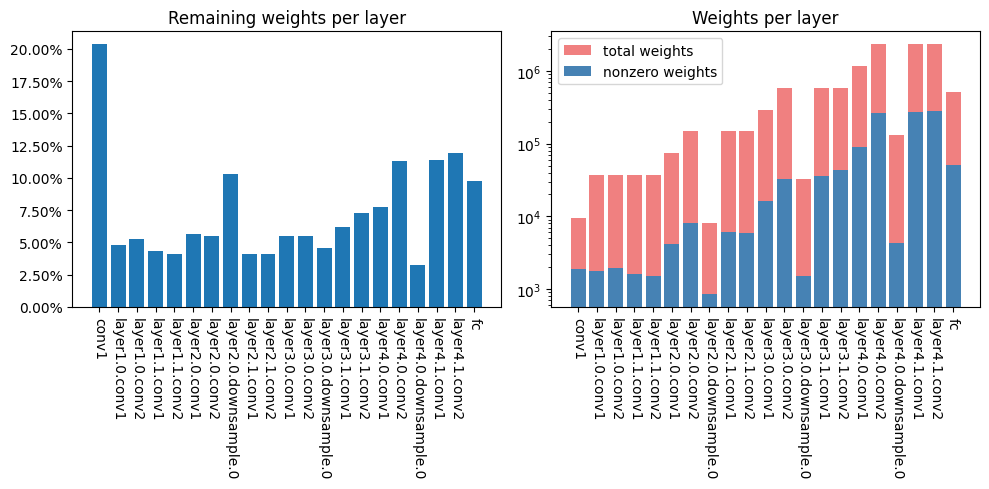

In [9]:
import numpy as np
from pquant import remove_pruning_from_model
import matplotlib.pyplot as plt
# Remove compression layers, leaves Quantized activations in place
model = remove_pruning_from_model(trained_model, config)

# Plot remaining weights
names = []
remaining = []
total_w = []
nonzeros = []
for n, m in trained_model.named_modules():
    if isinstance(m, (torch.nn.Conv1d, torch.nn.Conv2d, torch.nn.Linear)):
        names.append(n)
        nonzero = np.count_nonzero(m.weight.detach().cpu())
        remaining_pct = nonzero / m.weight.numel()
        remaining.append(remaining_pct)
        total_w.append(m.weight.numel())
        nonzeros.append(nonzero)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].bar(range(len(names)), remaining)
ax[0].set_xticks(range(len(names)))
ax[0].set_xticklabels(names)
ax[0].tick_params(axis='x', labelrotation=270)
new_ytick = []
for i in ax[0].get_yticklabels():
    ytick = f"{float(i.get_text()) * 100:.2f}%"
    new_ytick.append(ytick)
ax[0].set_yticklabels(new_ytick)
ax[0].title.set_text("Remaining weights per layer")

ax[1].bar(range(len(nonzeros)), total_w, color="lightcoral", label="total weights")
ax[1].bar(range(len(nonzeros)), nonzeros, color="steelblue", label="nonzero weights")
ax[1].set_xticks(range(len(names)))
ax[1].set_xticklabels(names)
ax[1].tick_params(axis='x', labelrotation=270)
ax[1].title.set_text("Weights per layer")
ax[1].legend()
ax[1].set_yscale("log")

plt.tight_layout()
plt.show()

In [10]:
import math

def visualize_conv_patterns(model, layer_name, max_patterns_to_show=16):
    """
    Visualizes the dominant binary patterns for a specific convolutional layer.
    """
    target_module = None
    for name, module in model.named_modules():
        if name == layer_name and hasattr(module, "pruning_layer"):
            pruning_layer = module.pruning_layer
            if hasattr(pruning_layer, "metric_fn") and "PACAPattern" in pruning_layer.metric_fn.__class__.__name__:
                target_module = module
                break
    
    if target_module is None:
        print(f"Error: Could not find a PACA-pruned layer named '{layer_name}'.")
        return
        
    metric_fn = target_module.pruning_layer.metric_fn
    # Ensure dominant patterns are selected based on the final weights
    metric_fn._select_dominant_patterns(target_module.weight)
    
    patterns = metric_fn.dominant_patterns
    if patterns is None or patterns.shape[0] == 0:
        print(f"No dominant patterns found for layer '{layer_name}'.")
        return
        
    # Convert to NumPy for plotting
    patterns_np = keras.ops.convert_to_numpy(patterns)
    
    # Get original kernel shape from the weight tensor
    kernel_h, kernel_w = target_module.weight.shape[2], target_module.weight.shape[3]
    
    num_patterns = min(patterns_np.shape[0], max_patterns_to_show)
    
    # Create a subplot grid for the patterns
    cols = math.ceil(math.sqrt(num_patterns))
    rows = math.ceil(num_patterns / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    if isinstance(axes, plt.Axes):
        axes = [axes]
    else:
        axes = axes.flatten()

    
    fig.suptitle(f"Dominant Patterns for Layer: {layer_name} (found {patterns_np.shape[0]})", fontsize=16)
    
    for i in range(num_patterns):
        pattern_2d = patterns_np[i].reshape(kernel_h, kernel_w)
        print(pattern_2d.shape)
        print(pattern_2d)
        axes[i].imshow(pattern_2d, cmap='binary', vmin=0, vmax=1)
        axes[i].set_title(f"Pattern {i+1}")
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        
    # Hide any unused subplots
    for j in range(num_patterns, len(axes)):
        axes[j].axis('off')
        
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# --- How to use it in your notebook after training is finished ---
visualize_conv_patterns(model, 'layer1.0.conv1')

Error: Could not find a PACA-pruned layer named 'layer1.0.conv1'.


## Add PACA prunning
#### After pruning we will have multiple patterns, so we force all of them to have a lower num,ber of dominant patterns

In [11]:
import yaml 

with open("pquant/configs/config_mdmm_paca.yaml", 'r') as f:
    config = yaml.safe_load(f)
JSON(config)

<IPython.core.display.JSON object>

In [ ]:
import importlib
import pquant                       # make sure the top-level module is in scope

importlib.reload(pquant)            # re-executes pquant/__init__.py and submodules it imports

# Re-import the symbol(s) you need, or access them via the namespace
from pquant import add_compression_layers

In [12]:
from pquant import add_compression_layers
input_shape = (256,3,32,32)
model = add_compression_layers(model, config, input_shape)
model

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument weight in method wrapper_CUDA__native_batch_norm)

In [ ]:
def train_resnet(model, trainloader, device, loss_func, epoch, optimizer, scheduler, *args, **kwargs):
    first_batch = True
    for data in trainloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = quantizer(inputs, k=torch.tensor(1.), i=torch.tensor(0.), f=torch.tensor(7.)) # 8 bits input quantization
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        losses = get_model_losses(model, torch.tensor(0.).to(device))
        loss += losses
        loss.backward()

        if first_batch:
            print("\n ---- Checking Loss values ----")
            print("Loss:", loss_func(outputs, labels).item())
            print("Model Losses:", losses.item())
            print("--------------------------------------------------")

            for name, module in model.named_modules():
                if "conv1" in name and hasattr(module, "pruning_layer"):
                    pruning_layer = module.pruning_layer
                    if hasattr(pruning_layer, "metric_fn") and "PACAPattern" in pruning_layer.metric_fn.__class__.__name__:
                        metric_fn = pruning_layer.metric_fn
                        num_patterns = 0
                        if metric_fn.dominant_patterns is not None:
                            num_patterns = metric_fn.dominant_patterns.shape[0]

                        total_dist = metric_fn(module.weight).item()
                        num_kernels = module.weight.shape[0]
                        avg_dist = total_dist / num_kernels if num_kernels > 0 else 0

                        print(f"--- PACA Stats for {name} at Epoch {epoch} ---")
                        print(f"Num Patterns: {num_patterns}, Avg Pattern Dist: {avg_dist:.4f}")
                        print("--------------------------------------------------\n")
                        break
            first_batch = False

        optimizer.step()
        epoch += 1
        if scheduler is not None:
            scheduler.step()

def validate_resnet(model, testloader, device, loss_func, epoch, *args, **kwargs):
    correct = 0
    total = 0
    num_paca_patterns = 0
    avg_paca_dist = 0.0
    model.eval()
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = quantizer(inputs, k=torch.tensor(1.), i=torch.tensor(0.), f=torch.tensor(7.))
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        for name, module in model.named_modules():
            if "conv1" in name and hasattr(module, "pruning_layer"):
                pruning_layer = module.pruning_layer
                if hasattr(pruning_layer, "metric_fn") and "PACAPattern" in pruning_layer.metric_fn.__class__.__name__:
                    metric_fn = pruning_layer.metric_fn
                    if metric_fn.dominant_patterns is not None:
                        num_paca_patterns = metric_fn.dominant_patterns.shape[0]

                    total_dist = metric_fn(module.weight).item()
                    num_kernels = module.weight.shape[0]
                    avg_paca_dist = total_dist / num_kernels if num_kernels > 0 else 0
                    break

        ratio = get_layer_keep_ratio(model)
        print(f'Accuracy: {100 * correct / total:.2f}%, '
              f'Remaining Weights: {ratio * 100:.2f}%, '
              f'Num Patterns: {num_paca_patterns}, '
              f'Avg Pattern Dist: {avg_paca_dist:.4f}')

BATCH_SIZE = 256
train_loader, val_loader = get_cifar10_data(BATCH_SIZE)

## Create loss function, scheduler and optimizer

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingLR

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.0001, momentum=0.9)
scheduler = CosineAnnealingLR(optimizer, 200)
loss_function = nn.CrossEntropyLoss()

## Train model
Training time. We use the train_compressed_model function from pquant to train. We need to provide some parameters such as training and validation functions, their input parameters, the model and the config file. The function automatically adds pruning layers and replaces activations with a quantized variant, trains the model, and removes the pruning layers after training is done

In [ ]:
from pquant import iterative_train
"""
Inputs to train_resnet we defined previously are:
          model, trainloader, device, loss_func, epoch, optimizer, scheduler, **kwargs
"""

trained_model = iterative_train(model = model, 
                                config = config, 
                                train_func = train_resnet, 
                                valid_func = validate_resnet, 
                                trainloader = train_loader, 
                                testloader = val_loader, 
                                device = device, 
                                loss_func = loss_function,
                                optimizer = optimizer, 
                                scheduler = scheduler
                                )


 ---- Checking Loss values ----
Loss: 1.023564100265503
Model Losses: 0.0
--------------------------------------------------
--- PACA Stats for conv1 at Epoch 0 ---
Num Patterns: 1, Avg Pattern Dist: 0.0000
--------------------------------------------------

Accuracy: 70.08%, Remaining Weights: 96.59%, Num Patterns: 1, Avg Pattern Dist: 0.0000

 ---- Checking Loss values ----
Loss: 0.9040290713310242
Model Losses: 0.0
--------------------------------------------------
--- PACA Stats for conv1 at Epoch 197 ---
Num Patterns: 1, Avg Pattern Dist: 0.0000
--------------------------------------------------

Accuracy: 63.14%, Remaining Weights: 96.59%, Num Patterns: 1, Avg Pattern Dist: 0.0000

 ---- Checking Loss values ----
Loss: 0.9618150591850281
Model Losses: 0.0
--------------------------------------------------
--- PACA Stats for conv1 at Epoch 394 ---
Num Patterns: 1, Avg Pattern Dist: 0.0000
--------------------------------------------------

Accuracy: 73.10%, Remaining Weights: 96.

KeyboardInterrupt: 

(3, 3)
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]


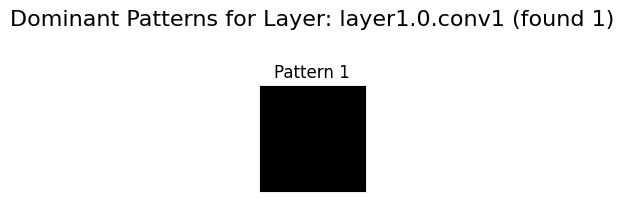

In [ ]:
visualize_conv_patterns(model, 'layer1.0.conv1')